In [1]:
import numpy as np
from scipy.io import mmread
from matplotlib import pyplot as plt
%matplotlib inline
L = 2 # domain length

# material parameters
nu = 0.25
E = 5.0/6.0 
rho = 1.0
K = E/(3*(1-2*nu))

c1 = np.sqrt( (1-nu)*E/((1+nu)*(1-2*nu)) / rho ) # uni-axial strain wave speed
cp = np.sqrt(K/rho) # p-wave speed

f = 1 # frequency
print(c1,cp)

1.0 0.7453559925


In [2]:
# load some python tools
from sys import path
path.append('/home/flo/cfs/code/share/python/')
from hdf5_tools import get_result, get_coordinates

In [3]:
# load the results
from h5py import File
h5 = File('uniaxStrainPwavePML3d.h5ref')
Uprop = get_result(h5,'mechDisplacement',region='prop')
Upml = get_result(h5,'mechDisplacement',region='pml')
Xprop = get_coordinates(h5,region='prop')
Xpml = get_coordinates(h5,region='pml')
X = h5['Mesh/Nodes/Coordinates'].value[::-1,:]
h5.close()
X
Is = np.lexsort( X.T ) # sort by z,y,x
X[Is,:]
z,Iz = np.unique(X[Is,-1],return_index=True)

In [4]:
# load the system matrix
Z = mmread('H_step_1_sys.mtx').toarray()
Z1s = Z[Is,:][:,Is]

# compute the matrix with only a single dof (instead of all 4 in the plane)
Z1d = np.array([Z1s[:,X[Is,-1]==zi].sum(axis=-1) for zi in z]).T[Iz,:]
Iprop = np.arange(1,5,1)
Ipml = -Iprop[::-1]
print(Z1d[Iprop,:][:,Iprop])
print(np.round(Z1d[Ipml,:][:,Ipml],decimals=3))

[[ 4.34202637+0.j -2.66449341+0.j  0.00000000+0.j  0.00000000+0.j]
 [-2.66449341+0.j  4.34202637+0.j -2.66449341+0.j  0.00000000+0.j]
 [ 0.00000000+0.j -2.66449341+0.j  4.34202637+0.j -2.66449341+0.j]
 [ 0.00000000+0.j  0.00000000+0.j -2.66449341+0.j  4.34202637+0.j]]
[[ 3.991+1.459j -2.489-0.594j  0.000+0.j     0.000+0.j   ]
 [-2.489-0.594j  3.991+1.459j -2.489-0.594j  0.000+0.j   ]
 [ 0.000+0.j    -2.489-0.594j  3.991+1.459j -2.489-0.594j]
 [ 0.000+0.j     0.000+0.j    -2.489-0.594j  1.995+0.729j]]


In [5]:
# load the stuff from the reference solution
from h5py import File
h5 = File('../../Acoustics/PlaneWavePML3d/PlaneWavePML3d.h5ref')
Paprop = get_result(h5,'acouPressure',region='prop')
Papml = get_result(h5,'acouPressure',region='pml')
Xaprop = get_coordinates(h5,region='prop')
Xapml = get_coordinates(h5,region='pml')
Xa = h5['Mesh/Nodes/Coordinates'].value[::-1,:]
h5.close()
Isa = np.lexsort( Xa.T ) # sort by z,y,x
Xa[Isa,:]
za,Iza = np.unique(Xa[Isa,-1],return_index=True)

# system matrix
Za = mmread('../../Acoustics/PlaneWavePML3d/PlaneWavePML3d_step_1_sys.mtx').toarray()
Z1sa = Za[Isa,:][:,Isa]

# compute the matrix with only a single dof (instead of all 4 in the plane)
Z1da = np.array([Z1sa[:,Xa[Isa,-1]==zi].sum(axis=-1) for zi in za]).T[Iza,:]
print(Z1da[Iprop,:][:,Iprop])
print(np.round(Z1da[Ipml,:][:,Ipml],decimals=3))

[[ 4.34202637+0.j -2.66449341+0.j  0.00000000+0.j  0.00000000+0.j]
 [-2.66449341+0.j  4.34202637+0.j -2.66449341+0.j  0.00000000+0.j]
 [ 0.00000000+0.j -2.66449341+0.j  4.34202637+0.j -2.66449341+0.j]
 [ 0.00000000+0.j  0.00000000+0.j -2.66449341+0.j  4.34202637+0.j]]
[[ 3.991+1.459j -2.489-0.594j  0.000+0.j     0.000+0.j   ]
 [-2.489-0.594j  3.991+1.459j -2.489-0.594j  0.000+0.j   ]
 [ 0.000+0.j    -2.489-0.594j  3.991+1.459j -2.489-0.594j]
 [ 0.000+0.j     0.000+0.j    -2.489-0.594j  1.995+0.729j]]


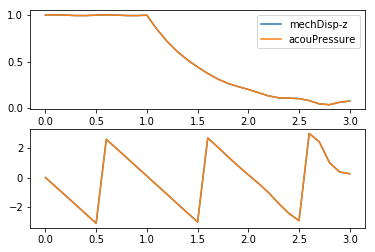

In [6]:
# plot a comparison to the solution
zh5,Izh5 = np.unique(np.vstack([Xprop,Xpml])[:,-1],return_index=True)
Uzh5 = np.vstack([Uprop,Upml])[Izh5,-1]
zh5a,Izh5a = np.unique(np.vstack([Xaprop,Xapml])[:,-1],return_index=True)
Pazh5 = np.hstack([Paprop,Papml])[Izh5a]
fig,axs = plt.subplots(nrows=2,ncols=1)
axs[0].plot(zh5,np.abs(Uzh5),label='mechDisp-z')
axs[0].plot(zh5a,np.abs(Pazh5),label='acouPressure')
axs[1].plot(zh5,np.angle(Uzh5))
axs[1].plot(zh5a,np.angle(Pazh5))
axs[0].legend()

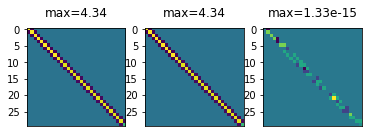

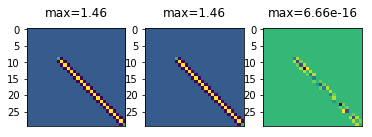

In [7]:
# compare the system matrices
Z1e = Z1da-Z1d # diff between acoustic and mechanic
Zs = [Z1d, Z1da, Z1e] # matrices to plot

fig,axs=plt.subplots(ncols=len(Zs))
for ax,Zi in zip(axs,Zs) :
    Zp = Zi[1:,:][:,1:] # do not plot penalty element
    ax.matshow(Zp.real)
    ax.set_title('max=%.3g'%np.max(np.abs(Zp.real)))
    ax.set_xticks([])

# imag
fig,axs=plt.subplots(ncols=len(Zs))
for ax,Zi in zip(axs,Zs) :
    Zp = Zi[1:,:][:,1:] # do not plot penalty element
    ax.matshow(Zp.imag)
    ax.set_title('max=%.3g'%np.max(np.abs(Zp.imag)))
    ax.set_xticks([])    